-----------------------------------
Random Forest accuracy on trial 1 : 0.6598173515981736
Random Forest accuracy on trial 2 : 0.6461187214611872
Random Forest accuracy on trial 3 : 0.589041095890411
Random Forest accuracy on trial 4 : 0.6050228310502284
Random Forest accuracy on trial 5 : 0.6141552511415526
Average Random Forest accuracy: 0.6228310502283105
XGBoost accuracy on trial 1 : 0.5839080459770115
Average XGBoost accuracy: 0.5839080459770115


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


Mean cross-validation score (neg root mean squared error): -758.04


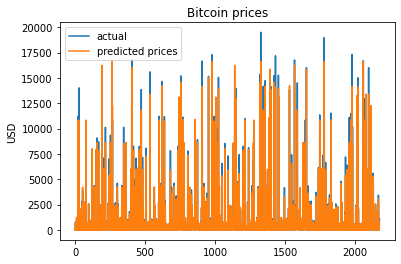

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


Mean cross-validation score (neg root mean squared error): -730.14


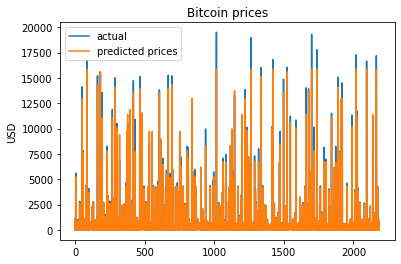

(2333, 4, 23) (2333,)
Epoch 1/50
62/62 [==============================] - 2s 12ms/step - loss: 75049.9741 - mean_absolute_error: 154.1826 - val_loss: 175048.7031 - val_mean_absolute_error: 399.7440
Epoch 2/50
62/62 [==============================] - 0s 4ms/step - loss: 79108.0727 - mean_absolute_error: 164.1673 - val_loss: 175126.5938 - val_mean_absolute_error: 399.8021
Epoch 3/50
62/62 [==============================] - 0s 4ms/step - loss: 75893.3317 - mean_absolute_error: 156.9306 - val_loss: 175204.3438 - val_mean_absolute_error: 399.8470
Epoch 4/50
62/62 [==============================] - 0s 4ms/step - loss: 78202.2138 - mean_absolute_error: 160.1796 - val_loss: 175262.1562 - val_mean_absolute_error: 399.8444
Epoch 5/50
62/62 [==============================] - 0s 4ms/step - loss: 81166.5828 - mean_absolute_error: 163.5651 - val_loss: 175258.6094 - val_mean_absolute_error: 399.7387
Epoch 6/50
62/62 [==============================] - 0s 4ms/step - loss: 77296.4911 - mean_absolute_err

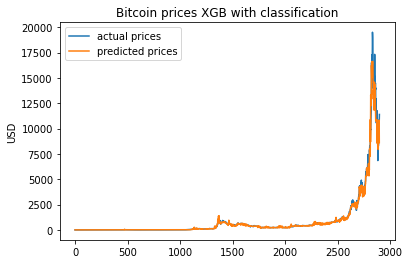

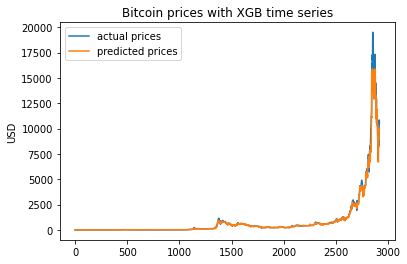

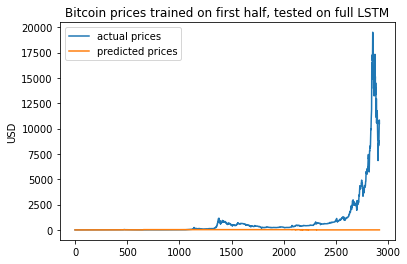

In [7]:
import pandas as pd
import keras
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier



def loadData_mlp(path):
    raw = pd.read_csv(path)
    # remove NaNs
    raw = raw[raw.isnull()['btc_trade_volume'] == False]
    x = raw.values[1:, 2:]
    y = raw.values[:, 1]
    # turn y into up/down data
    y = y[1:] - y[:-1] <= np.zeros(len(y) - 1)
    #print(x.shape, y.shape)
    # ensure numpy arrays
    x = np.asarray(x).astype('float32')
    y = np.asarray(y).astype('float32')
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    # ensure no NaNs are being introduced by input data
    return x, y

def loadData_xgb_reg(path):
    raw = pd.read_csv(path)
    # remove NaNs
    raw = raw[raw.isnull()['btc_trade_volume'] == False]
    x = raw.values[1:, 2:]
    y = raw.values[:, 1]
    # turn y into up/down data
    #y = y[1:] - y[:-1] <= np.zeros(len(y) - 1)
    #print(x.shape, y.shape)
    # ensure numpy arrays
    x = np.asarray(x).astype('float32')
    y = np.asarray(y).astype('float32')
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    # ensure no NaNs are being introduced by input data
    return x, y

def loadData_lstm(path):
    raw = pd.read_csv(path)
    raw['btc_trade_volume'] = raw['btc_trade_volume'].fillna(0)
    x = raw.values[:-3, 1:]
    # x1 = raw.shift(-1).values[:-1, 1:]
    for i in range(3):
        x1 = raw.shift(-i).values[:-3, 1:]
        x = np.concatenate((x,x1),axis = 1)
    y = raw.shift(-1).values[:-3, 1]
    # ensure numpy arrays
    # x = np.asarray(x).astype('float32')
    # x1 = np.asarray(x1).astype('float32')
    # y = np.asarray(y).astype('float32')
    # x = np.concatenate((x,x1),axis = 1)
    #print('this is x_shape', x.shape)
    x = np.asarray(x).astype('float32')
    y = np.asarray(y).astype('float32')
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    #x = np.reshape(x, (len(x),2,23))
    return x, y


############
## MODELS ##
############
def xgboost_clas(x,y, args=None):
    data_dmatrix = xgb.DMatrix(data=x,label=y)
    params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
    xgbc = XGBClassifier()
    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
        n_estimators=100, n_jobs=1, nthread=None,
        objective='multi:softprob', random_state=0, reg_alpha=0,
        reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
        subsample=1, verbosity=1) 
    accuracy = []
    v= 1
    for i in range(v):
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=0.15
        )
        model = xgbc.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        print("XGBoost accuracy on trial",i+1,":",accuracy_score(y_test, y_pred))
        accuracy += [accuracy_score(y_test, y_pred)]
    print("Average XGBoost accuracy:", np.mean(accuracy))
    return model

def randomForest(x,y, args=None):
    classifier = RandomForestClassifier(n_jobs=15, n_estimators=200, bootstrap=True,
                                        max_depth=10)
    accuracy = 0
    v=5
    for i in range(v):
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=0.15
        )
        model = classifier.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        print("Random Forest accuracy on trial",i+1,":",accuracy_score(y_test, y_pred))
        accuracy += accuracy_score(y_test, y_pred)
    print("Average Random Forest accuracy:", accuracy/v)

### MULTILAYER PERCEPTRON ###



def mlp(x_train, y_train, args=None):
    # Define model architecture
    model = keras.Sequential([keras.layers.Input(shape=(22)),
                              keras.layers.Dense(128),
                              keras.layers.Activation(keras.activations.relu),
                              keras.layers.Dense(256),
                              keras.layers.Dense(128),
                              keras.layers.Dense(1),
                              keras.layers.Activation(keras.activations.sigmoid)
                              ])
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=args['LR'])
    # Compilation
    model.compile(optimizer=opt,
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    # Training
    history = model.fit(x=x_train,
                        y=y_train,
                        epochs=args['epochs'],
                        validation_split=0.1)
    return model, history


### LSTM ###
def lstm(x, y, args=None):
    # Define model architecture
    j = 4*len(y)//5
    x=x[:j,:]
    y=y[:j]
    x = np.reshape(x, (len(x),4,23))
    model = keras.Sequential([keras.layers.LSTM(50),
                              keras.layers.Dense(1),
                              ])
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=args['LR'])
    # Compilation
    model.compile(optimizer=opt,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    # Training
    print(x.shape, y.shape)
    history = model.fit(x=x,
                        y=y,
                        epochs=args['epochs'],
                        validation_split=0.15)
    return model, history

def xgboost_reg(x,y, args=None):
    params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
    # j = 9*len(y)//10
    x = x[:,:]
    y= y[:]
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.75
    )
    # x_train, y_train = x, y
    # x_test, y_test = x,y
    data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)
    #xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, 
                                learning_rate = 0.3, max_depth = 5, alpha = 10, n_estimators = 10, n_jobs = 7)
    scores = cross_val_score(xg_reg, x, y,cv=10, verbose= 1, scoring='neg_root_mean_squared_error')
    print("Mean cross-validation score (neg root mean squared error): %.2f" % scores.mean())
    xg_reg.fit(x_train,y_train)
    y_pred = xg_reg.predict(x_test)
    plt.plot(y_test, label='actual')
    plt.plot(y_pred, label='predicted prices')
    plt.title('Bitcoin prices')
    plt.ylabel('USD')
    plt.legend(loc='best')
    plt.show()
    return xg_reg

if __name__ == '__main__':
    mlp_args = {'LR': 0.00005, 'epochs': 30}
    lstm_args = {'LR': 0.0001, 'epochs': 50}
    d, d1 = loadData_lstm('bitcoin_dataset.csv')
    x, y = loadData_mlp('bitcoin_dataset.csv')
    a, b= loadData_xgb_reg('bitcoin_dataset.csv')
    ##model, hist = mlp(x, y, args=mlp_args)
    d2 = d1[1:] - d1[:-1] <= np.zeros(len(d1) - 1)
    d2 = np.append(d2,[1<0])
    print("-----------------------------------")
    # randomForest(x, y, args= mlp_args)
    randomForest(d, d2, args= mlp_args)
    xgboost_model = xgboost_clas(x,y)
    pred = xgboost_model.predict(x)
    pred += [0]
    gum = []
    for ind, val in enumerate(pred):
        gum.append([val])
    x = np.append(x,gum, axis= 1)
    #print('this is x shape:', x.shape, "y shape:", b.shape)
    model1 = xgboost_reg(x,b[:-1])
    # model1.fit(x,b[:-1])
    model2 = xgboost_reg(d,d1)
    model3, hist1 = lstm(d, d1, args=lstm_args)

    plt.title('Bitcoin prices XGB with classification')
    plt.ylabel('USD')
    plt.plot(b, label = 'actual prices')
    plt.plot(model1.predict(x), label='predicted prices')
    plt.legend(loc='best')
    plt.show()


    plt.title('Bitcoin prices with XGB time series')
    plt.ylabel('USD')
    plt.plot(d1, label = 'actual prices')
    plt.plot(model2.predict(d), label='predicted prices')
    plt.legend(loc='best')
    plt.show()

    # plt.title('Bitcoin prices')
    # plt.ylabel('USD')
    # plt.plot(d1, label = 'actual prices')
    # plt.xlabel('Days since February 23, 2010')
    # # plt.plot(model2.predict(d), label='predicted prices')
    # plt.legend(loc='best')
    # plt.show()

    plt.title('Bitcoin prices trained on first half, tested on full LSTM')
    plt.ylabel('USD')
    plt.plot(d1, label = 'actual prices')
    d = np.reshape(d,(len(d),4,23))
    plt.plot(model3.predict(d), label='predicted prices')
    plt.legend(loc='best')
    plt.show()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
